# **Sequence of words predictions**

## The basics of Natural Language Model to understand ChatGPT

## ***By Rodrigo Guarneros Gutiérrez***

<span style="color:DarkGreen; font-size: 30px;">Introducción</span>

De acuerdo con nuestra referencia principal Manning, C. & Schütze (1999), una oración (nuestro elemento lingüistico básico para el ejercicio de análisis) se define como algo que termina regularmente con los signos de puntuación ".", "?" o "!". Teniendo cuidado de lo que implican algunos puntos que se utilizan en abreviaturas o puntos suspensivos. Sin embargo, a pesar de esta salvedad se ha demostrado que esta clasificación básica de las oraciones, el 90% de los puntos en un texto son indicadores de límite de las oraciones, de acuerdo con Riley (1989). De acuerdo con Manning y Shütze, existen otras salvedades de las que hay que estar conscientes como sería el caso de ";", ":" y "-", y que podrían ser pensados como sentencias por si mismas.

En esta ocasión, se realiza el siguiente desarrollo:

1. **Obtener la información:** Abriendo el archivo que ECMAScript o JavaScript.
2. **Normalizar la información:** Con base en las recomendaciones realizadas y teniendo cuidado de no eliminar aquellos symbolos que de acuerdo a la literatura se consideran como límites de las oraciones, conforme a lo señalado en el primer párrafo de esta introducción.
3. **Crear el modelo:** Para ello se parte de la caja de herramientas para lenguaje natural de Python denominada (NLTK, por sus siglas en inglés). Para mayor información diríjase a la sección final de este notebook.
Para este punto:
    - Se crea un directorio para las probabilidades y otra para las frecuencias de cada bigrama
    - Se utiliza la función defaultdict utiliza los valores de cada lista para hacer un diccionario
    - Para excluir los markadores de cada oración del cálculo de probabilidades se filtra por bigrama, recordemos que la función sent_tokenize identifica las oraciones en el texto y genera los marcadores, que no deben considerarse para el cálculo de probabilidades.
    - Se cuentan los bigramas (C(xy)) y la primera palabra de los bigramas (C(x))
    - Se crea el diccionario
    - Se calcula la probabilidad de cada bigrama como p(x|y) = C(xy)/c(x)
    - Se calculan las probabilidades (es hasta este punto donde se modifica un poco la fórmula para hacer un suavizamiento de acuerdo a Laplace)
    - Se comparan los modelos con y sin suavizamiento de Laplace.
4. **Almacenar las probabilidades resultado de cada modelo:** La serialización binaria de las probabilidades hizo más rápida su consulta en el siguiente paso (Gracias).
5. **Crear la función con una interacción:** Se trata de una función que le pregunta al usuario sobre la palabra que se busca y rankea las 5 palabras más importantes, en función de su probabilidad conjunta.


<span style="color:DarkGreen; font-size: 30px;">Desarrollo</span>

<span style="color:Blue; font-size: 30px;">1. 1. Calcular los modelos de probabilidad MLE y MLE con suavizado de Laplace para un modelo de bigramas. Con el corpus "europarl.es"</span>

Para el preprocesamiento de datos:

* Como son documentos oficiales, los datos están bien escritos
* Convertir a minúsculas, borrar puntuación y usar marcadores de inicio y fin de oración, para facilidad del ejercicio considerar cada línea como una oración sin necesidad de encontrar las oraciones por cada párrafo.

In [1]:
# Dependencias: 
import io
import os
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import unicodedata
import math
import seaborn as sns
import numpy as np
import nltk
import string
import pickle
from scipy.stats import rankdata

### 1. Obteniendo la información

In [2]:

# Abriendo el archivo que ECMAScript o JavaScript
with open('europarl.es', 'r', encoding='utf-8') as archivo:
    # leer el contenido del archivo
    contenido = archivo.read()

# Print el contenido del archivo
print('Procesando y obteniendo una muestra de los primeros 500 elementos...')
print(contenido[0:500])
# Print la extensión del archivo
print(f'El archivo contiene {len(contenido)} letras')
file_size = os.path.getsize('europarl.es')
print(f'El archivo tiene una extensión de {file_size/1024000} MB')

Procesando y obteniendo una muestra de los primeros 500 elementos...
declaro reanudado el período de sesiones del parlamento europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a sus señorías mi deseo de que hayan tenido unas buenas vacaciones .
como todos han podido comprobar , el gran `` efecto del año 2000 '' no se ha producido . en cambio , los ciudadanos de varios de nuestros países han sido víctimas de catástrofes naturales verdaderamente terribles .
sus señorías han solicitado un debate sobre el tema para los próximos días , en el curso de
El archivo contiene 15891924 letras
El archivo tiene una extensión de 15.7962080078125 MB


### 2. Convertir a minúsculas, borrar puntuación y usar marcadores de inicio y fin de oración, para facilidad del ejercicio considerar cada línea como una oración sin necesidad de encontrar las oraciones por cada párrafo.

In [3]:
# considerar todos los símbolos y convertir el texto a minúsculas
# Acentos
# Creamos la función para remover acentos, tal y como se presenta en la clase MCDI-PI-02.

def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

elementos_totales = len(contenido)
string_no_acentos = remove_accents(contenido)
string_no_acentos[:500] # confirmar eliminación de acentos.

"declaro reanudado el periodo de sesiones del parlamento europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a sus senorias mi deseo de que hayan tenido unas buenas vacaciones .\ncomo todos han podido comprobar , el gran `` efecto del ano 2000 '' no se ha producido . en cambio , los ciudadanos de varios de nuestros paises han sido victimas de catastrofes naturales verdaderamente terribles .\nsus senorias han solicitado un debate sobre el tema para los proximos dias , en el curso de"

### 3. Normalicemos las mayúsculas

In [4]:
# parece que ya fue normalizado el texto para incluir sólo minúsculas, pero vamos a normalizar nuevamente
string_no_acentos_minusc = string_no_acentos.lower()
string_no_acentos_minusc[:500]

"declaro reanudado el periodo de sesiones del parlamento europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a sus senorias mi deseo de que hayan tenido unas buenas vacaciones .\ncomo todos han podido comprobar , el gran `` efecto del ano 2000 '' no se ha producido . en cambio , los ciudadanos de varios de nuestros paises han sido victimas de catastrofes naturales verdaderamente terribles .\nsus senorias han solicitado un debate sobre el tema para los proximos dias , en el curso de"

### 4. Búsqueda de símbolos y eliminación

In [5]:

# Contemos cada carácter de cada texto en nuestra lista maestra para verificar qué símbolos tenemos.

string_lista_acentos_dic = Counter(string_no_acentos_minusc)
simbolos_en_string = list(string_lista_acentos_dic.keys())
print(simbolos_en_string)

['d', 'e', 'c', 'l', 'a', 'r', 'o', ' ', 'n', 'u', 'p', 'i', 's', 'm', 't', ',', 'v', '1', '7', 'b', 'y', 'q', 'h', '.', '\n', 'g', '`', 'f', '2', '0', "'", 'x', 'z', '-', 'k', '¿', '?', '4', '3', 'j', '6', '9', '8', ':', ';', '5', '/', 'w', '%', '"', '¡', '!', 'ø', '«', '»', '\xad', '+', 'μ', 'æ', 'ß', '_', '·', 'ð', '&', '=']


In [6]:
# Eliminamos los símbolos de puntuación que no nos serán útiles para identificar las oraciones (como unidad lingüistica mínima) en los términos de Manning, C. & Schütze (1999), página 134.
# De tal forma que los símbolos que nos reservamos son: ".", "...", "?", "!", ":", ";", "-" y '"'.
string_normalizado = string_no_acentos_minusc
simbolos_eliminar = [' ',  "\n", '`', "'",  '/', '%',  'ø', '\xad', '+', 'μ', 'æ', 'ß', '_', '·', 'ð', '&', '=', '``',"''", "`"]

for simbolo in simbolos_eliminar:
    string_normalizado = string_normalizado.replace(simbolo, " ")
    
print(string_normalizado[:600])



declaro reanudado el periodo de sesiones del parlamento europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a sus senorias mi deseo de que hayan tenido unas buenas vacaciones . como todos han podido comprobar , el gran    efecto del ano 2000    no se ha producido . en cambio , los ciudadanos de varios de nuestros paises han sido victimas de catastrofes naturales verdaderamente terribles . sus senorias han solicitado un debate sobre el tema para los proximos dias , en el curso de este periodo de sesiones . a la espera de que se produzca , de acuerdo con muchos colegas que me lo


In [7]:
# Se busca el modelo a partir la del documentación de NLTK

nltk.download('punkt')

# Se tokeniza el texto en oraciones icluyendo como símbolos de alto en las oraciones pre-establecidos en el módulo punkt '., '?' y '!'. 
# En todo caso considera como puntuación interna en una oración ', : '

oraciones = nltk.sent_tokenize(string_normalizado, language='spanish')

# A cada oración se incluye el marcador de incio y final
oraciones_marcadas = []

for oracion in oraciones:
    oracion_marcada = "<s> " + oracion.strip() + " </s>"
    oraciones_marcadas.append(oracion_marcada)

# Veamos los 6 primeros tokens para fonfirmar
oraciones_marcadas[:6]


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rodri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['<s> declaro reanudado el periodo de sesiones del parlamento europeo , interrumpido el viernes 17 de diciembre pasado , y reitero a sus senorias mi deseo de que hayan tenido unas buenas vacaciones . </s>',
 '<s> como todos han podido comprobar , el gran    efecto del ano 2000    no se ha producido . </s>',
 '<s> en cambio , los ciudadanos de varios de nuestros paises han sido victimas de catastrofes naturales verdaderamente terribles . </s>',
 '<s> sus senorias han solicitado un debate sobre el tema para los proximos dias , en el curso de este periodo de sesiones . </s>',
 '<s> a la espera de que se produzca , de acuerdo con muchos colegas que me lo han pedido , pido que hagamos un minuto de silencio en memoria de todas las victimas de las tormentas , en los distintos paises de la union europea afectados . </s>',
 '<s> invito a todos a que nos pongamos de pie para guardar un minuto de silencio . </s>']

In [8]:
oraciones_spliteadas = [string.split() for string in oraciones_marcadas]
flat_list = [palabra for oracion in oraciones_spliteadas for palabra in oracion]
print(flat_list[:60])

['<s>', 'declaro', 'reanudado', 'el', 'periodo', 'de', 'sesiones', 'del', 'parlamento', 'europeo', ',', 'interrumpido', 'el', 'viernes', '17', 'de', 'diciembre', 'pasado', ',', 'y', 'reitero', 'a', 'sus', 'senorias', 'mi', 'deseo', 'de', 'que', 'hayan', 'tenido', 'unas', 'buenas', 'vacaciones', '.', '</s>', '<s>', 'como', 'todos', 'han', 'podido', 'comprobar', ',', 'el', 'gran', 'efecto', 'del', 'ano', '2000', 'no', 'se', 'ha', 'producido', '.', '</s>', '<s>', 'en', 'cambio', ',', 'los', 'ciudadanos']


In [9]:
# En virtud de lo anterior, ya no son necesarios los puntos, comas, signos de interrogación y admiración en el texto deconstruido, toda vez que tenemos los marcadores de final de palabra.

simbolos_a_remover = ['.', '¿','?', ',', ';',':', '!', '¡']

texto_final = [palabra for palabra in flat_list if palabra not in simbolos_a_remover]

print(texto_final[:60])


['<s>', 'declaro', 'reanudado', 'el', 'periodo', 'de', 'sesiones', 'del', 'parlamento', 'europeo', 'interrumpido', 'el', 'viernes', '17', 'de', 'diciembre', 'pasado', 'y', 'reitero', 'a', 'sus', 'senorias', 'mi', 'deseo', 'de', 'que', 'hayan', 'tenido', 'unas', 'buenas', 'vacaciones', '</s>', '<s>', 'como', 'todos', 'han', 'podido', 'comprobar', 'el', 'gran', 'efecto', 'del', 'ano', '2000', 'no', 'se', 'ha', 'producido', '</s>', '<s>', 'en', 'cambio', 'los', 'ciudadanos', 'de', 'varios', 'de', 'nuestros', 'paises', 'han']


In [10]:
from collections import defaultdict
from nltk import bigrams

# se crea un directorio para las probabilidades y otra para las frecuencias de cada bigrama
# el defaultdict utiliza los valores de cada lista para hacer un diccionario
bigram_counts = defaultdict(float)
unigram_counts = defaultdict(float)

# para excluir los markadores de cada oración del cálculo de probabilidades se filtra por bigrama de la siguiente forma
por_bigrama = [(p1, p2) for p1, p2 in bigrams(texto_final) if p1 not in ['<s>', '</s>'] and p2 not in ['<s>', '</s>']]

# Se cuentan los bigramas (C(xy)) y la primera palabra de los bigramas (C(x))
for bigram in por_bigrama:
    bigram_counts[bigram] += 1
    unigram_counts[bigram[0]] += 1

# Se crea el diccionario
mle_prob = {}

# Calculamos la probabilidad de cada bigrama como p(x|y) = C(xy)/c(x)
for bigram in bigram_counts:
    if unigram_counts[bigram[0]] > 0:
        mle_prob[bigram] = bigram_counts[bigram] / unigram_counts[bigram[0]] #tenemos algunos ceros lo que se puede resolver mejor con MLE suavizado de Laplace
    else:
        mle_prob[bigram] = 0

# definimos las keys para el respectivo diccionario
keys_to_update = list(mle_prob.keys())

# Actualizamos el MLE probabilidades
for bigram in keys_to_update:
    mle_prob[bigram] += 1
    unigram_counts[bigram[0]] += 1
    mle_prob[bigram] /= unigram_counts[bigram[0]] # Equivalente a mle_prob[bigram] = mle_prob[bigram] / contador_p1[bigram[0]] 

In [11]:
# ¿Cómo se ve?

mle_prob_aslist = list(mle_prob.items())
mle_prob_aslist[:10]

[(('declaro', 'reanudado'), 0.016171993911719938),
 (('reanudado', 'el'), 0.10661764705882353),
 (('el', 'periodo'), 1.4900490578373517e-05),
 (('periodo', 'de'), 0.0020859333214476735),
 (('de', 'sesiones'), 5.7636475525803115e-06),
 (('sesiones', 'del'), 0.004910096818810512),
 (('del', 'parlamento'), 3.625573629471103e-05),
 (('parlamento', 'europeo'), 0.0002294027066284984),
 (('europeo', 'interrumpido'), 0.0002962928859537466),
 (('interrumpido', 'el'), 0.04038461538461539)]

In [12]:
# Serializando los resultados:
# import pickle
# archivo_nombre = "mle_prob.pickle"

# with open(archivo_nombre, "wb") as archivo:
#     pickle.dump(mle_prob_aslist, archivo) # serializa y escribe el archivo
#     archivo.close()

In [13]:
with open('mle_prob.pickle', 'rb') as archivo:
    mle_prob_read = pickle.load(archivo)

mle_prob_read[:5]

[(('declaro', 'reanudado'), 0.016171993911719938),
 (('reanudado', 'el'), 0.10661764705882353),
 (('el', 'periodo'), 1.4900490578373517e-05),
 (('periodo', 'de'), 0.0020859333214476735),
 (('de', 'sesiones'), 5.7636475525803115e-06)]

# Suavizamiento de Laplace

In [14]:
# se crea un directorio para las probabilidades y otra para las frecuencias de cada bigrama
# el defaultdict utiliza los valores de cada lista para hacer un diccionario
bigram_counts = defaultdict(float)
unigram_counts = defaultdict(float)

# para excluir los markadores de cada oración del cálculo de probabilidades se filtra por bigrama de la siguiente forma
por_bigrama = [(p1, p2) for p1, p2 in bigrams(texto_final) if p1 not in ['<s>', '</s>'] and p2 not in ['<s>', '</s>']]

constante = 1 # factor de suavizamiento
V = len(set(por_bigrama))

# Se cuentan los bigramas (C(xy)) y la primera palabra de los bigramas (C(x))
for bigram in por_bigrama:
    bigram_counts[bigram] += 1
    unigram_counts[bigram[0]] += 1

# Se crea el diccionario
mle_prob_laplace = {}

# Calculamos la probabilidad de cada bigrama como p(x|y) = C(xy)/c(x)

for bigram in bigram_counts:
    numerator = bigram_counts[bigram] + constante
    denominator = unigram_counts[bigram[0]] + V
    mle_prob_laplace[bigram] = numerator / denominator
    
#  definimos las keys para el respectivo diccionario
keys_to_update_laplace = list(mle_prob_laplace.keys())

#  Actualizamos el MLE probabilidades suavizado
for bigram in keys_to_update_laplace:
    mle_prob_laplace[bigram] += 1
    unigram_counts[bigram[0]] += 1
    mle_prob_laplace[bigram] /= unigram_counts[bigram[0]] # Equivalente a mle_prob[bigram] = mle_prob[bigram] / contador_p1[bigram[0]] 

In [15]:
# ¿Cómo se ve?

mle_prob_aslist_laplace = list(mle_prob_laplace.items())
mle_prob_aslist_laplace[:10]


[(('declaro', 'reanudado'), 0.013699005372895779),
 (('reanudado', 'el'), 0.058825140895473874),
 (('el', 'periodo'), 1.4852801949587804e-05),
 (('periodo', 'de'), 0.0014074152276635043),
 (('de', 'sesiones'), 5.758585482526461e-06),
 (('sesiones', 'del'), 0.004149742811178282),
 (('del', 'parlamento'), 3.4514203590983246e-05),
 (('parlamento', 'europeo'), 0.00017367080391960432),
 (('europeo', 'interrumpido'), 0.00029525399225530346),
 (('interrumpido', 'el'), 0.025001222945988832)]

In [16]:
# # Serializando los resultados de laplace:
# archivo_nombre = "mle_prob_laplace.pickle"

# with open(archivo_nombre, "wb") as archivo:
#     pickle.dump(mle_prob_aslist_laplace, archivo) # serializa y escribe el archivo
#     archivo.close()

In [17]:
with open('mle_prob_laplace.pickle', 'rb') as archivo:
    mle_prob_laplace_read = pickle.load(archivo)

mle_prob_laplace_read[:10]

[(('declaro', 'reanudado'), 0.013699005372895779),
 (('reanudado', 'el'), 0.058825140895473874),
 (('el', 'periodo'), 1.4852801949587804e-05),
 (('periodo', 'de'), 0.0014074152276635043),
 (('de', 'sesiones'), 5.758585482526461e-06),
 (('sesiones', 'del'), 0.004149742811178282),
 (('del', 'parlamento'), 3.4514203590983246e-05),
 (('parlamento', 'europeo'), 0.00017367080391960432),
 (('europeo', 'interrumpido'), 0.00029525399225530346),
 (('interrumpido', 'el'), 0.025001222945988832)]

2. Calcular si la siguientes oraciones son posibles, es decir, calcular las probabilidades de las siguientes oraciones usando el modelo de MLE y MLE con suavizado de Laplace. Comparar las probabilidades.


In [18]:
oraciones = ["<s> el parlamento debe enviar un mensaje </s>", 
             "<s> el parlamento debe enviar un consejo </s>", 
             "<s> el abismo entre pobres y ricos </s>", 
             "<s> el abismo entre ricos y pobres </s>", 
             "<s> el abismo de la cantera entre pobres y ricos </s>",
             "<s> la comisión debe ser totalmente transparente </s>", 
             "<s> la comisión debe ser transparente </s>"]

# vamos a tokenizar las oraciones a evaluar y obtener sus bigramas, eliminado los marcadores

oraciones_no_markers = [string.replace("<s>", "").replace("</s>", "") for string in oraciones]

bigramas_evaluar = []
    
for oracion in oraciones_no_markers:
    palabras = oracion.split()
    bi_tokens = list(bigrams(palabras))
    bigramas_evaluar.append(bi_tokens)

bigramas_evaluar[:2]


[[('el', 'parlamento'),
  ('parlamento', 'debe'),
  ('debe', 'enviar'),
  ('enviar', 'un'),
  ('un', 'mensaje')],
 [('el', 'parlamento'),
  ('parlamento', 'debe'),
  ('debe', 'enviar'),
  ('enviar', 'un'),
  ('un', 'consejo')]]

In [19]:
probs = {}
for sublist in bigramas_evaluar:
    for bigram in sublist:
        if bigram in mle_prob_read:
            continue
        for item in mle_prob_read:
            if item[0] == bigram:
                probs[bigram] = item[1]
                break
probs

{('el', 'parlamento'): 1.54567890511996e-05,
 ('parlamento', 'debe'): 0.00017477495033538308,
 ('debe', 'enviar'): 0.00026983264484794567,
 ('enviar', 'un'): 0.012422360248447204,
 ('un', 'mensaje'): 4.3361177323396743e-05,
 ('un', 'consejo'): 4.287857836056767e-05,
 ('el', 'abismo'): 1.4825140380802275e-05,
 ('abismo', 'entre'): 0.05789473684210526,
 ('entre', 'pobres'): 0.00023485524981129889,
 ('pobres', 'y'): 0.0048984241503702295,
 ('y', 'ricos'): 1.5283058447547118e-05,
 ('entre', 'ricos'): 0.0002483856168201708,
 ('ricos', 'y'): 0.021152829190904287,
 ('y', 'pobres'): 1.634548095218921e-05,
 ('abismo', 'de'): 0.039473684210526314,
 ('de', 'la'): 6.781856874297818e-06,
 ('debe', 'ser'): 0.00031106008374918293,
 ('ser', 'totalmente'): 0.00023789001573085072,
 ('totalmente', 'transparente'): 0.0018456345715362934,
 ('ser', 'transparente'): 0.0002129760447906217}

In [20]:
mle_prob_read = dict(mle_prob_read)

product_probs = []

for sublist in bigramas_evaluar:
    sublist_product = 1
    for bigram in sublist:
        sublist_product *= probs.get(bigram, mle_prob_read.get(bigram, 0))
    product_probs.append(sublist_product)

In [21]:
product_probs

[3.9264325613875485e-19,
 3.8827323576866336e-19,
 1.50905418061912e-17,
 7.37106954413135e-17,
 0.0,
 0.0,
 0.0]

# Laplace

In [22]:
probs_laplace = {}
for sublist in bigramas_evaluar:
    for bigram in sublist:
        if bigram in mle_prob_laplace_read:
            continue
        for item in mle_prob_laplace_read:
            if item[0] == bigram:
                probs_laplace[bigram] = item[1]
                break
probs_laplace

{('el', 'parlamento'): 1.4916612114287642e-05,
 ('parlamento', 'debe'): 0.00017282350854723488,
 ('debe', 'enviar'): 0.0002696165465299377,
 ('enviar', 'un'): 0.010869862947859995,
 ('un', 'mensaje'): 4.325558294430708e-05,
 ('un', 'consejo'): 4.281660315764843e-05,
 ('el', 'abismo'): 1.4823415993608711e-05,
 ('abismo', 'entre'): 0.050000391358031936,
 ('entre', 'pobres'): 0.00023479781243209704,
 ('pobres', 'y'): 0.004348081215616629,
 ('y', 'ricos'): 1.5282861792743376e-05,
 ('entre', 'ricos'): 0.0002481413667173085,
 ('ricos', 'y'): 0.01612966342882379,
 ('y', 'pobres'): 1.6343120924760588e-05,
 ('abismo', 'de'): 0.03571449537037425,
 ('de', 'la'): 6.016617904267452e-06,
 ('debe', 'ser'): 0.0002698413111520401,
 ('ser', 'totalmente'): 0.00023730929193073374,
 ('totalmente', 'transparente'): 0.0018348767332703854,
 ('ser', 'transparente'): 0.00021276802284295084}

In [23]:
mle_prob_laplace_read = dict(mle_prob_laplace_read)

product_probs_laplace = []

for sublist in bigramas_evaluar:
    sublist_product = 1
    for bigram in sublist:
        sublist_product *= probs_laplace.get(bigram, mle_prob_laplace_read.get(bigram, 0))
    product_probs_laplace.append(sublist_product)

In [24]:
product_probs_laplace

[3.268028185488032e-19,
 3.2348625634339475e-19,
 1.1564266183847993e-17,
 4.848207168681393e-17,
 0.0,
 0.0,
 0.0]

In [25]:
df = pd.DataFrame({'Oraciones':oraciones,'MLE':product_probs, 'MLE Suavizado Laplace':product_probs_laplace})
df = df.sort_values(by='MLE', ascending=True)
df

,Oraciones,MLE,MLE Suavizado Laplace
4,<s> el abismo de la cantera entre pobres y ric...,0.000000e+00,0.000000e+00
5,<s> la comisión debe ser totalmente transparen...,0.000000e+00,0.000000e+00
6,<s> la comisión debe ser transparente </s>,0.000000e+00,0.000000e+00
1,<s> el parlamento debe enviar un consejo </s>,3.882732e-19,3.234863e-19
0,<s> el parlamento debe enviar un mensaje </s>,3.926433e-19,3.268028e-19
2,<s> el abismo entre pobres y ricos </s>,1.509054e-17,1.156427e-17
3,<s> el abismo entre ricos y pobres </s>,7.371070e-17,4.848207e-17


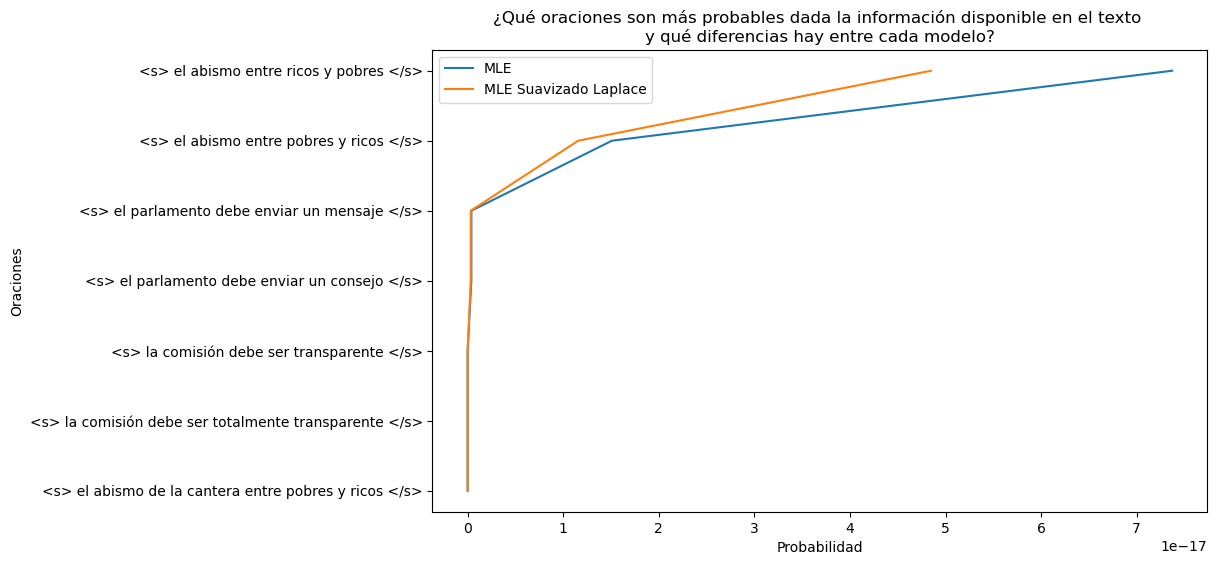

In [26]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df['MLE'], df['Oraciones'], label='MLE')
plt.plot(df['MLE Suavizado Laplace'], df['Oraciones'], label= 'MLE Suavizado Laplace')
plt.legend(loc='best') 
plt.title('¿Qué oraciones son más probables dada la información disponible en el texto \ny qué diferencias hay entre cada modelo?')
plt.xlabel('Probabilidad')
plt.ylabel('Oraciones')
plt.savefig("MLEvsMLELAP.png", dpi=300, bbox_inches='tight')
plt.show()

# 3. Predicción de palabras, dada una palabra inicial mostrar las siguientes cinco palabras más probables de acuerdo con los modelos MLE y MLE con suavizado de Laplace.

In [27]:
def pronostico_interactivo(bigram_dict):
    palabra_actual = ''
    
    while palabra_actual != 'salir':
        palabra_actual = input('Incluye la palabra a buscar (escriba "salir" para detener el servicio): ') # Creamos in input para que el usuario incluya su palabra
        if palabra_actual == 'salir':
            break
            
        candidatos = [] # creamos la lista de palabras candidatas
        
        for bigram, prob in bigram_dict.items():
            if palabra_actual == bigram[0]:
                candidatos.append((bigram[1], prob)) 
        
        if not candidatos:
            print(f"No se encontraron palabras relacionadas para la palabra elegida {palabra_actual}")
        
        else:
            
            ordenar_candidatos = sorted(candidatos, key=lambda x: -x[1])
            print(f"Las cinco palabras con mayor probabilidad de estar asociadas con la plabra '{palabra_actual}' son:")
            
            for candidato, prob in ordenar_candidatos[:5]:
                print(f"  '{candidato}' -> P({candidato}|{palabra_actual}) = {prob:.2e}")

# Probando en MLE suavidado Laplace la función interactiva

In [ ]:
pronostico_interactivo(mle_prob_laplace_read)

Incluye la palabra a buscar (escriba "salir" para detener el servicio):  pobres


Las cinco palabras con mayor probabilidad de estar asociadas con la plabra 'pobres' son:
  'y' -> P(y|pobres) = 4.35e-03
  'de' -> P(de|pobres) = 4.33e-03
  'siguen' -> P(siguen|pobres) = 4.31e-03
  'entre' -> P(entre|pobres) = 4.29e-03
  'suplen' -> P(suplen|pobres) = 4.27e-03


Incluye la palabra a buscar (escriba "salir" para detener el servicio):  y


Las cinco palabras con mayor probabilidad de estar asociadas con la plabra 'y' son:
  'de' -> P(de|y) = 1.65e-05
  'la' -> P(la|y) = 1.65e-05
  'que' -> P(que|y) = 1.64e-05
  'el' -> P(el|y) = 1.64e-05
  'en' -> P(en|y) = 1.64e-05


# Probando MLE en la función interactiva

In [ ]:
pronostico_interactivo(mle_prob_read)

# Probar con el inicio de la palabra "la"
# Probar con el inicio de la palabra "parlamento"

In [ ]:
# Primero MLE 
pronostico_interactivo(mle_prob_read)

In [ ]:
# Segundo con MLE Suavizado Laplace
pronostico_interactivo(mle_prob_laplace_read)

# Incluir 3 ejemplos para demostrar sus modelos de predicción "interactiva". 

In [ ]:
pronostico_interactivo_interactivo(mle_prob_read)

<span style="color:DarkGreen; font-size: 30px;">Conclusiones</span>

1. Salvo su mejor opinión, creo que los pronósticos elaborados con base en las probabilidades conjuntas de los bigramas en el texto son relativamente buenos en la medida que nos proporcionan un resultado esperado en función de la naturaleza del texto que sierve como base.

2. Con los modelos creados y probados para las oraciones específicas, se confirma que el suavizamiento de Laplace no cambia la estructura de la distribución de probabilidades, pero las reduce (suaviza), tomando en cuenta que la base (denominador) de la fórmula de probabilidades aumenta y se ajusta considerablemente en función del tamaño del texto; atendiendo de mejor manera a aquellas palabras con menor proababilidad.

<center>
  <img src="MLEvsMLELAP.png" alt="image">
</center>

3. Me quedé con ganas de hacer una función interactiva para trigramas, pero ya no hay tiempo. 

4. Gracias, excelente actividad, aunque me faya aún mi código y los hago muy largos.



### Bibliografía y referencias electrónicas

- Library NLTK para entender el método sent_tokenize y el módulo PunktSentenceTokenizer. Disponible en: https://www.nltk.org/api/nltk.tokenize.html y en https://www.nltk.org/api/nltk.tokenize.punkt.html#:~:text=Punkt%20Sentence%20Tokenizer,before%20it%20can%20be%20used. 
- Using List as default_factory en Geek for Geeks. Disponible en: https://www.geeksforgeeks.org/defaultdict-in-python/.
- Information entropy | Journey into information theory | Computer Science | Khan Academy: https://youtu.be/2s3aJfRr9gE
- Jurafsky, D. & Martin, J.H. (2008). Speech and Language Processing. Prentice Hall, Segunda Edición.
- Manning, C. & Schütze, H. (1999). Foundations of Statistical Natural Language Processing, MIT Press. Cambridge, MA. 
- Chen, R.,  Haitao L. & Altmann, G. (2016). Entropy in different text types. Digital Scholarship in the Humanities, vol. 32, Issue 3, pp. 528–542.
- Text Normalization for Natural Language Processing in Python. Disponible en: https://lvngd.com/blog/text-normalization-natural-language-processing-python/


In [ ]:
(1835-0)/3338.11